# SARSA & Q-Learning CartPole

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import time
import random
from itertools import product


GAMMA = 0.99

# Hyperparameters (shared for SARSA and Q-Learning)
N_EPISODES = 30_000
MAX_STEPS = 500
ALPHA = 0.1
EPS_START = 1.0
EPS_END = 0.05

SEED_LIST = list(range(1, 11)) 
BASE_B = 7

print("Seed list:", SEED_LIST)
print("Base grid size:", BASE_B)

Seed list: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Base grid size: 7


In [2]:

def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)

TERMINAL = (-1, -1, -1, -1)

def make_n_bins(b: int):
    """Map scalar grid size to per-dimension bins (same pattern as VI/PI)."""
    return [b, b, 2 * b, 2 * b]

def build_states(n_bins_vec):
    states = list(product(*(range(n) for n in n_bins_vec)))
    states.append(TERMINAL)
    return states

def get_cartpole_bounds(env):
    low = env.observation_space.low.astype(np.float64).copy()
    high = env.observation_space.high.astype(np.float64).copy()
    # Cap unbounded dimensions
    low[1] = -3.0
    high[1] = 3.0
    low[3] = -3.0
    high[3] = 3.0
    return low, high

def discretize_state(obs, n_bins_vec, state_low, state_high):
    ratios = (obs - state_low) / (state_high - state_low)
    ratios = np.clip(ratios, 0.0, 0.9999)
    bins = [int(r * n) for r, n in zip(ratios, n_bins_vec)]
    return tuple(bins)


# ------------------------------
# Epsilon-greedy policy
# ------------------------------
def epsilon_greedy(Q, state_idx, eps, n_actions=2):
    if np.random.rand() < eps:
        return np.random.randint(n_actions)
    else:
        return int(np.argmax(Q[state_idx]))


# ------------------------------
# SARSA algorithm (on-policy)
# ------------------------------
def sarsa_train(env,
                n_bins_vec,
                state_low,
                state_high,
                states,
                state_to_idx,
                n_episodes=N_EPISODES,
                max_steps=MAX_STEPS,
                alpha=ALPHA,
                gamma=GAMMA,
                eps_start=EPS_START,
                eps_end=EPS_END):
    """
    Tabular SARSA on discretized CartPole.
    Returns:
        Q:      (n_states, n_actions)
        returns_per_episode: length n_episodes
        deltaQ_per_episode:  length n_episodes (max |ΔQ| in that episode)
    """
    n_actions = 2
    n_states = len(state_to_idx)
    Q = np.zeros((n_states, n_actions), dtype=np.float64)

    returns = np.zeros(n_episodes, dtype=np.float64)
    delta_Q = np.zeros(n_episodes, dtype=np.float64)

    for ep in range(n_episodes):
        # Linear epsilon decay
        frac = ep / max(1, n_episodes - 1)
        eps = eps_start + frac * (eps_end - eps_start)

        obs, _ = env.reset()
        s = discretize_state(obs, n_bins_vec, state_low, state_high)
        s_idx = state_to_idx[s]

        a = epsilon_greedy(Q, s_idx, eps, n_actions=n_actions)

        total_r = 0.0
        max_delta_this_ep = 0.0

        for t in range(max_steps):
            next_obs, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total_r += r

            if done:
                target = r  # no next Q term
                s_next_idx = None
                a_next = None
            else:
                s_next = discretize_state(next_obs, n_bins_vec, state_low, state_high)
                s_next_idx = state_to_idx[s_next]
                a_next = epsilon_greedy(Q, s_next_idx, eps, n_actions=n_actions)
                target = r + gamma * Q[s_next_idx, a_next]

            old_q = Q[s_idx, a]
            Q[s_idx, a] = old_q + alpha * (target - old_q)
            delta = abs(Q[s_idx, a] - old_q)
            if delta > max_delta_this_ep:
                max_delta_this_ep = delta

            if done:
                break

            # move on
            obs = next_obs
            s_idx = s_next_idx
            a = a_next

        returns[ep] = total_r
        delta_Q[ep] = max_delta_this_ep

    return Q, returns, delta_Q


# ------------------------------
# Q-Learning algorithm (off-policy)
# ------------------------------
def q_learning_train(env,
                     n_bins_vec,
                     state_low,
                     state_high,
                     states,
                     state_to_idx,
                     n_episodes=N_EPISODES,
                     max_steps=MAX_STEPS,
                     alpha=ALPHA,
                     gamma=GAMMA,
                     eps_start=EPS_START,
                     eps_end=EPS_END):
    """
    Tabular Q-Learning on discretized CartPole.
    Returns:
        Q:      (n_states, n_actions)
        returns_per_episode: length n_episodes
        deltaQ_per_episode:  length n_episodes (max |ΔQ| in that episode)
    """
    n_actions = 2
    n_states = len(state_to_idx)
    Q = np.zeros((n_states, n_actions), dtype=np.float64)

    returns = np.zeros(n_episodes, dtype=np.float64)
    delta_Q = np.zeros(n_episodes, dtype=np.float64)

    for ep in range(n_episodes):
        # Linear epsilon decay
        frac = ep / max(1, n_episodes - 1)
        eps = eps_start + frac * (eps_end - eps_start)

        obs, _ = env.reset()
        s = discretize_state(obs, n_bins_vec, state_low, state_high)
        s_idx = state_to_idx[s]

        total_r = 0.0
        max_delta_this_ep = 0.0

        for t in range(max_steps):
            # Choose action ε-greedily from current state
            a = epsilon_greedy(Q, s_idx, eps, n_actions=n_actions)

            next_obs, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total_r += r

            old_q = Q[s_idx, a]

            if done:
                target = r  # terminal
            else:
                s_next = discretize_state(next_obs, n_bins_vec, state_low, state_high)
                s_next_idx = state_to_idx[s_next]
                # Off-policy: bootstrap from max_a' Q(s', a')
                target = r + gamma * np.max(Q[s_next_idx])

            Q[s_idx, a] = old_q + alpha * (target - old_q)
            delta = abs(Q[s_idx, a] - old_q)
            if delta > max_delta_this_ep:
                max_delta_this_ep = delta

            if done:
                break

            # move to next state
            s_idx = s_next_idx

        returns[ep] = total_r
        delta_Q[ep] = max_delta_this_ep

    return Q, returns, delta_Q


# ------------------------------
# Evaluation helper (greedy policy)
# ------------------------------
def q_to_policy(Q, states, state_to_idx):
    policy = {}
    for s in states:
        if s == TERMINAL:
            continue
        idx = state_to_idx[s]
        policy[s] = int(np.argmax(Q[idx]))
    return policy

def evaluate_policy(env,
                    policy,
                    n_bins_vec,
                    state_low,
                    state_high,
                    n_episodes=50,
                    max_steps=MAX_STEPS):
    returns = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_r = 0.0
        steps = 0
        while not done and steps < max_steps:
            s = discretize_state(obs, n_bins_vec, state_low, state_high)
            a = policy.get(s, 0)
            obs, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            total_r += r
            steps += 1
        returns.append(total_r)
    return np.array(returns, dtype=np.float64)


# ------------------------------
# Plot helpers
# ------------------------------
def plot_mean_iqr(curves, title, ylabel, filename,
                  x_label="Episode", ylog=False):
    """
    curves: list of 1D arrays, one per seed.
    Plots mean with IQR band.
    """
    if len(curves) == 0:
        return

    max_len = max(len(c) for c in curves)
    mat = np.full((len(curves), max_len), np.nan)
    for i, c in enumerate(curves):
        mat[i, :len(c)] = c

    mean = np.nanmean(mat, axis=0)
    q25 = np.nanpercentile(mat, 25, axis=0)
    q75 = np.nanpercentile(mat, 75, axis=0)
    xs = np.arange(max_len)

    plt.figure(figsize=(6, 4))
    plt.plot(xs, mean, label="mean")
    plt.fill_between(xs, q25, q75, alpha=0.3, label="IQR")
    if ylog:
        plt.yscale("log")
    plt.xlabel(x_label)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

def plot_mean_std_over_seeds(returns_per_seed, title, filename):
    """
    returns_per_seed: list of 1D arrays (n_episodes),
    Build mean ± std across seeds at each episode.
    """
    if len(returns_per_seed) == 0:
        return

    max_len = max(len(c) for c in returns_per_seed)
    mat = np.full((len(returns_per_seed), max_len), np.nan)
    for i, c in enumerate(returns_per_seed):
        mat[i, :len(c)] = c

    mean = np.nanmean(mat, axis=0)
    std = np.nanstd(mat, axis=0)
    xs = np.arange(max_len)

    plt.figure(figsize=(6, 4))
    plt.plot(xs, mean, label="mean return")
    plt.fill_between(xs, mean - std, mean + std, alpha=0.3, label="±1 std")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title(title)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

def plot_compare_learning_curves(curves_a, curves_b,
                                 label_a, label_b,
                                 title, filename):
    """
    Compare two algorithms by plotting mean + IQR for each on same axes.
    """
    if len(curves_a) == 0 or len(curves_b) == 0:
        return

    def stats_from_curves(curves):
        max_len = max(len(c) for c in curves)
        mat = np.full((len(curves), max_len), np.nan)
        for i, c in enumerate(curves):
            mat[i, :len(c)] = c
        mean = np.nanmean(mat, axis=0)
        q25 = np.nanpercentile(mat, 25, axis=0)
        q75 = np.nanpercentile(mat, 75, axis=0)
        return mean, q25, q75

    mean_a, q25_a, q75_a = stats_from_curves(curves_a)
    mean_b, q25_b, q75_b = stats_from_curves(curves_b)
    xs = np.arange(len(mean_a))

    plt.figure(figsize=(6, 4))
    plt.plot(xs, mean_a, label=f"{label_a} mean")
    plt.fill_between(xs, q25_a, q75_a, alpha=0.25, label=f"{label_a} IQR")

    plt.plot(xs, mean_b, label=f"{label_b} mean")
    plt.fill_between(xs, q25_b, q75_b, alpha=0.25, label=f"{label_b} IQR")

    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title(title)
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()


# ------------------------------
# Main experiment
# ------------------------------


Running SARSA for seed 1
Running SARSA for seed 2
Running SARSA for seed 3
Running SARSA for seed 4
Running SARSA for seed 5
Running SARSA for seed 6
Running SARSA for seed 7
Running SARSA for seed 8
Running SARSA for seed 9
Running SARSA for seed 10

Total SARSA wall-clock over all seeds: 791.95 s
Running Q-Learning for seed 1
Running Q-Learning for seed 2
Running Q-Learning for seed 3
Running Q-Learning for seed 4
Running Q-Learning for seed 5
Running Q-Learning for seed 6
Running Q-Learning for seed 7
Running Q-Learning for seed 8
Running Q-Learning for seed 9
Running Q-Learning for seed 10

Total Q-Learning wall-clock over all seeds: 960.54 s


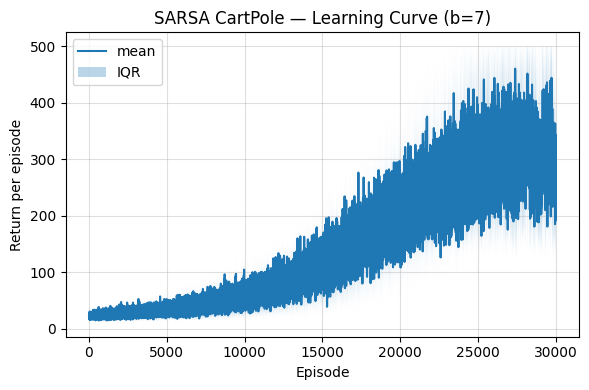

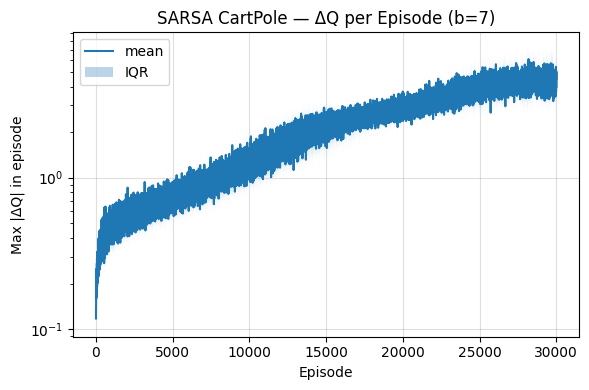

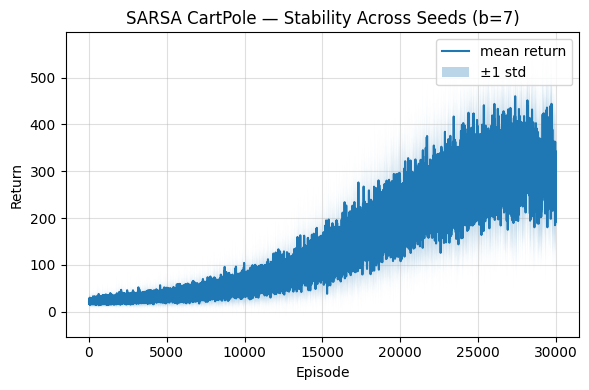


SARSA evaluation returns (greedy policy) per seed:
  Seed 1: mean return = 344.48
  Seed 2: mean return = 323.20
  Seed 3: mean return = 497.90
  Seed 4: mean return = 179.08
  Seed 5: mean return = 446.70
  Seed 6: mean return = 361.72
  Seed 7: mean return = 139.34
  Seed 8: mean return = 206.30
  Seed 9: mean return = 171.40
  Seed 10: mean return = 185.76
SARSA overall mean ± std: 285.59 ± 119.89


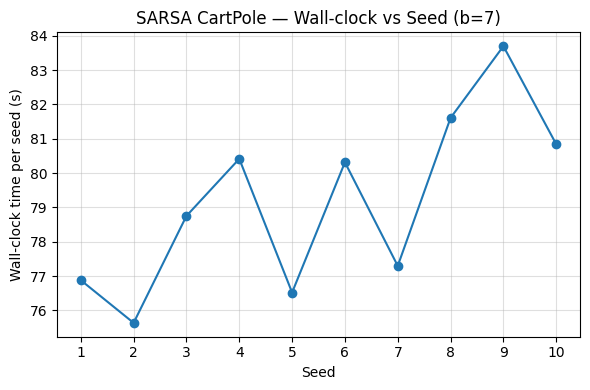

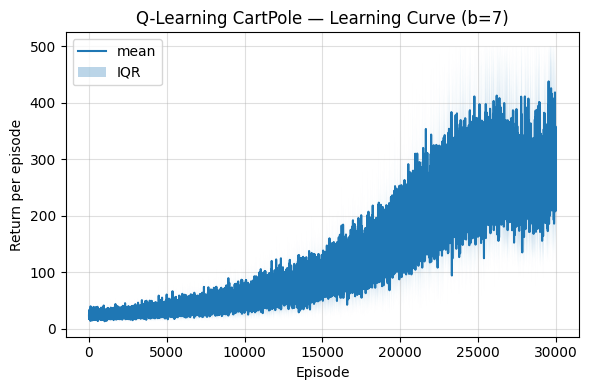

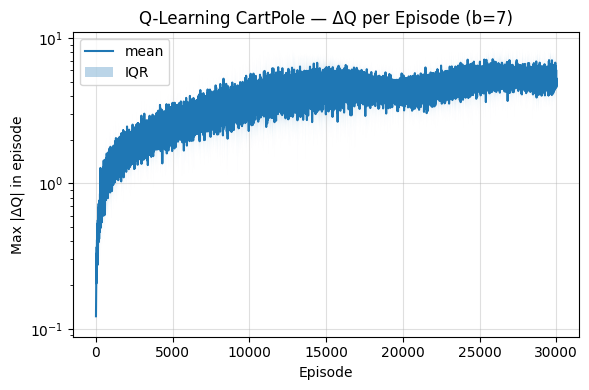

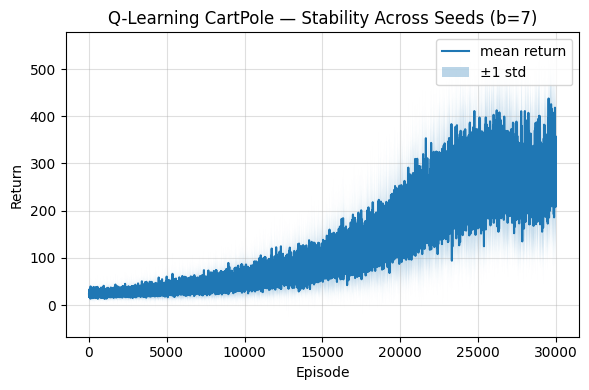


Q-Learning evaluation returns (greedy policy) per seed:
  Seed 1: mean return = 477.66
  Seed 2: mean return = 101.26
  Seed 3: mean return = 236.46
  Seed 4: mean return = 210.12
  Seed 5: mean return = 368.24
  Seed 6: mean return = 302.64
  Seed 7: mean return = 343.96
  Seed 8: mean return = 326.92
  Seed 9: mean return = 312.36
  Seed 10: mean return = 126.36
Q-Learning overall mean ± std: 280.60 ± 108.18


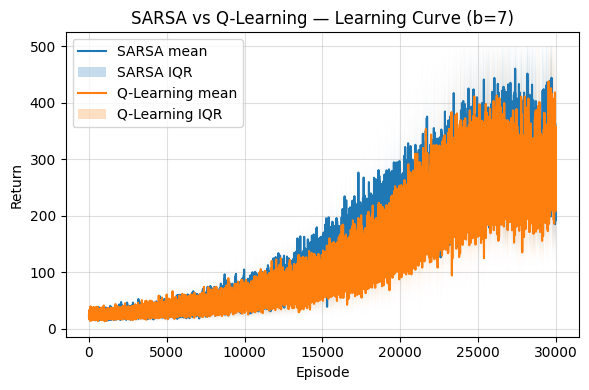

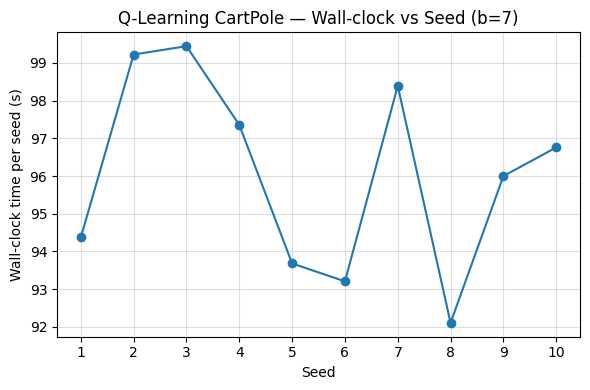


Done. Figures saved as:
  - cartpole_sarsa_learning_curve_b7.pdf
  - cartpole_sarsa_deltaQ_b7.pdf
  - cartpole_sarsa_stability_b7.pdf
  - cartpole_sarsa_wallclock_vs_seed_b7.pdf
  - cartpole_qlearning_learning_curve_b7.pdf
  - cartpole_qlearning_deltaQ_b7.pdf
  - cartpole_qlearning_stability_b7.pdf
  - cartpole_qlearning_wallclock_vs_seed_b7.pdf
  - cartpole_sarsa_vs_qlearning_learning_curve_b7.pdf


In [3]:

actions = [0, 1]
b = BASE_B
n_bins_vec = make_n_bins(b)
states = build_states(n_bins_vec)

# mapping from state -> index (exclude TERMINAL from Q)
state_to_idx = {s: i for i, s in enumerate(states) if s != TERMINAL}

# Containers for SARSA
sarsa_returns_all = []
sarsa_deltaQ_all = []
sarsa_eval_returns = []
sarsa_wallclock_per_seed = []
sarsa_total_wallclock = 0.0

# Containers for Q-Learning
q_returns_all = []
q_deltaQ_all = []
q_eval_returns = []
q_wallclock_per_seed = []
q_total_wallclock = 0.0


# ============
# Run SARSA
# ============
for seed in SEED_LIST:
    print(f"Running SARSA for seed {seed}")
    set_seed(seed)
    env = gym.make("CartPole-v1")

    state_low, state_high = get_cartpole_bounds(env)

    t0 = time.time()
    Q_sarsa, returns_ep, deltaQ_ep = sarsa_train(
        env,
        n_bins_vec,
        state_low,
        state_high,
        states,
        state_to_idx,
        n_episodes=N_EPISODES,
        max_steps=MAX_STEPS,
        alpha=ALPHA,
        gamma=GAMMA,
        eps_start=EPS_START,
        eps_end=EPS_END,
    )
    elapsed = time.time() - t0
    sarsa_total_wallclock += elapsed
    sarsa_wallclock_per_seed.append(elapsed)

    sarsa_returns_all.append(returns_ep)
    sarsa_deltaQ_all.append(deltaQ_ep)

    policy_sarsa = q_to_policy(Q_sarsa, states, state_to_idx)
    eval_ret_sarsa = evaluate_policy(
        env,
        policy_sarsa,
        n_bins_vec,
        state_low,
        state_high,
        n_episodes=50,
        max_steps=MAX_STEPS,
    )
    sarsa_eval_returns.append(eval_ret_sarsa.mean())

    env.close()

print(f"\nTotal SARSA wall-clock over all seeds: {sarsa_total_wallclock:.2f} s")


# ============
# Run Q-Learning
# ============
for seed in SEED_LIST:
    print(f"Running Q-Learning for seed {seed}")
    set_seed(seed)
    env = gym.make("CartPole-v1")

    state_low, state_high = get_cartpole_bounds(env)

    t0 = time.time()
    Q_q, returns_ep_q, deltaQ_ep_q = q_learning_train(
        env,
        n_bins_vec,
        state_low,
        state_high,
        states,
        state_to_idx,
        n_episodes=N_EPISODES,
        max_steps=MAX_STEPS,
        alpha=ALPHA,
        gamma=GAMMA,
        eps_start=EPS_START,
        eps_end=EPS_END,
    )
    elapsed = time.time() - t0
    q_total_wallclock += elapsed
    q_wallclock_per_seed.append(elapsed)

    q_returns_all.append(returns_ep_q)
    q_deltaQ_all.append(deltaQ_ep_q)

    policy_q = q_to_policy(Q_q, states, state_to_idx)
    eval_ret_q = evaluate_policy(
        env,
        policy_q,
        n_bins_vec,
        state_low,
        state_high,
        n_episodes=50,
        max_steps=MAX_STEPS,
    )
    q_eval_returns.append(eval_ret_q.mean())

    env.close()

print(f"\nTotal Q-Learning wall-clock over all seeds: {q_total_wallclock:.2f} s")


# ------------------------------
# SARSA-specific figures (you already had these)
# ------------------------------
plot_mean_iqr(
    sarsa_returns_all,
    title=f"SARSA CartPole — Learning Curve (b={b})",
    ylabel="Return per episode",
    filename=f"cartpole_sarsa_learning_curve_b{b}.pdf",
    x_label="Episode",
    ylog=False,
)

plot_mean_iqr(
    sarsa_deltaQ_all,
    title=f"SARSA CartPole — ΔQ per Episode (b={b})",
    ylabel="Max |ΔQ| in episode",
    filename=f"cartpole_sarsa_deltaQ_b{b}.pdf",
    x_label="Episode",
    ylog=True,
)

plot_mean_std_over_seeds(
    sarsa_returns_all,
    title=f"SARSA CartPole — Stability Across Seeds (b={b})",
    filename=f"cartpole_sarsa_stability_b{b}.pdf",
)

sarsa_eval_returns = np.array(sarsa_eval_returns, dtype=np.float64)
print("\nSARSA evaluation returns (greedy policy) per seed:")
for seed, r in zip(SEED_LIST, sarsa_eval_returns):
    print(f"  Seed {seed}: mean return = {r:.2f}")
print(f"SARSA overall mean ± std: {sarsa_eval_returns.mean():.2f} ± {sarsa_eval_returns.std():.2f}")

plt.figure(figsize=(6, 4))
plt.plot(SEED_LIST, sarsa_wallclock_per_seed, "-o")
plt.xlabel("Seed")
plt.ylabel("Wall-clock time per seed (s)")
plt.title(f"SARSA CartPole — Wall-clock vs Seed (b={b})")
plt.grid(True, alpha=0.4)
plt.xticks(SEED_LIST)
plt.tight_layout()
plt.savefig(f"cartpole_sarsa_wallclock_vs_seed_b{b}.pdf")
plt.show()


# ------------------------------
# Q-Learning — Required figures
# ------------------------------

# 1) Learning curve: return vs episodes
plot_mean_iqr(
    q_returns_all,
    title=f"Q-Learning CartPole — Learning Curve (b={b})",
    ylabel="Return per episode",
    filename=f"cartpole_qlearning_learning_curve_b{b}.pdf",
    x_label="Episode",
    ylog=False,
)

# 2) ΔQ vs episodes
plot_mean_iqr(
    q_deltaQ_all,
    title=f"Q-Learning CartPole — ΔQ per Episode (b={b})",
    ylabel="Max |ΔQ| in episode",
    filename=f"cartpole_qlearning_deltaQ_b{b}.pdf",
    x_label="Episode",
    ylog=True,
)

# 3) Stability plot (variance / std across seeds)
plot_mean_std_over_seeds(
    q_returns_all,
    title=f"Q-Learning CartPole — Stability Across Seeds (b={b})",
    filename=f"cartpole_qlearning_stability_b{b}.pdf",
)

q_eval_returns = np.array(q_eval_returns, dtype=np.float64)
print("\nQ-Learning evaluation returns (greedy policy) per seed:")
for seed, r in zip(SEED_LIST, q_eval_returns):
    print(f"  Seed {seed}: mean return = {r:.2f}")
print(f"Q-Learning overall mean ± std: {q_eval_returns.mean():.2f} ± {q_eval_returns.std():.2f}")

# 4) SARSA vs Q-Learning combined learning curve
plot_compare_learning_curves(
    sarsa_returns_all,
    q_returns_all,
    label_a="SARSA",
    label_b="Q-Learning",
    title=f"SARSA vs Q-Learning — Learning Curve (b={b})",
    filename=f"cartpole_sarsa_vs_qlearning_learning_curve_b{b}.pdf",
)

# 5) Wall-clock Time vs seed (Q-Learning)
plt.figure(figsize=(6, 4))
plt.plot(SEED_LIST, q_wallclock_per_seed, "-o")
plt.xlabel("Seed")
plt.ylabel("Wall-clock time per seed (s)")
plt.title(f"Q-Learning CartPole — Wall-clock vs Seed (b={b})")
plt.grid(True, alpha=0.4)
plt.xticks(SEED_LIST)
plt.tight_layout()
plt.savefig(f"cartpole_qlearning_wallclock_vs_seed_b{b}.pdf")
plt.show()

print("\nDone. Figures saved as:")
print(f"  - cartpole_sarsa_learning_curve_b{b}.pdf")
print(f"  - cartpole_sarsa_deltaQ_b{b}.pdf")
print(f"  - cartpole_sarsa_stability_b{b}.pdf")
print(f"  - cartpole_sarsa_wallclock_vs_seed_b{b}.pdf")
print(f"  - cartpole_qlearning_learning_curve_b{b}.pdf")
print(f"  - cartpole_qlearning_deltaQ_b{b}.pdf")
print(f"  - cartpole_qlearning_stability_b{b}.pdf")
print(f"  - cartpole_qlearning_wallclock_vs_seed_b{b}.pdf")
print(f"  - cartpole_sarsa_vs_qlearning_learning_curve_b{b}.pdf")
